## Código proyecto semestral IIQ2003 - G8

### Modelamiento de un sistema TES sometido a radiación solar y por reflejo de espejos

### Definición de variables

In [ ]:
import math
#condiciones de operación
p_0 = 3*101325 #presión inicial [Pa]
p_f = 101325 #presión final [Pa]
T_0 = 285+273.15 #temperatura inicial [K]

#propiedades del fluido
Tref=285
rho = 2090-0.636*Tref #densidad [kg/m^3]
mu = (22.714-0.12*Tref+2.281*10**(-4)*Tref**(2)-1.474*10**(-7)*Tref**3)*10**(-3) #viscosidad [Pa*s]
c_p = 1443-0.172*Tref #capacidad calorífica [J/kg*K]
k = 0.443+1.9*10**(-4)*Tref #conductividad térmica [W/m*K]

#Dimensiones de la tubería
R = 6*10**(-3) #Radio [m]
L = 1 #Largo [m]

g = 9.81 #gravedad [m/s^2]

#constantes del problema
Phi = ((p_f-p_0)/L-rho*g)/(4*mu)
qrad=400*1000 #radiación en la frontera [W/m^2]


## 2. Resolución por SOR
### 2.1 Creación de la malla

In [ ]:
# Visualización de datos y gráficos
import matplotlib.pyplot as plt

# Computación numérica
import numpy as np

In [ ]:
# Grilla estructurada en coordenadas x e y para representar receptáculo cuadrado

# Definimos el número de puntos deseados en nuestra grilla
Nz = 71
Nr = 21

# Definimos vectores con las coordenadas de cada punto en el espacio donde se evaluará la solución.
z_grilla = np.linspace(0.0, L, Nz)
r_grilla = np.linspace(0.0, R, Nr)

# Calculamos el paso o espaciamiento para cada coordenada.
dz = L/(Nz-1)
dr = R/(Nr-1)

# Imprimimos los resultados
print("dz = %.3f, dr = %.3f m" % (dz, dr))

dz = 0.014, dr = 0.000 m


### 2.2 Visualización de la malla

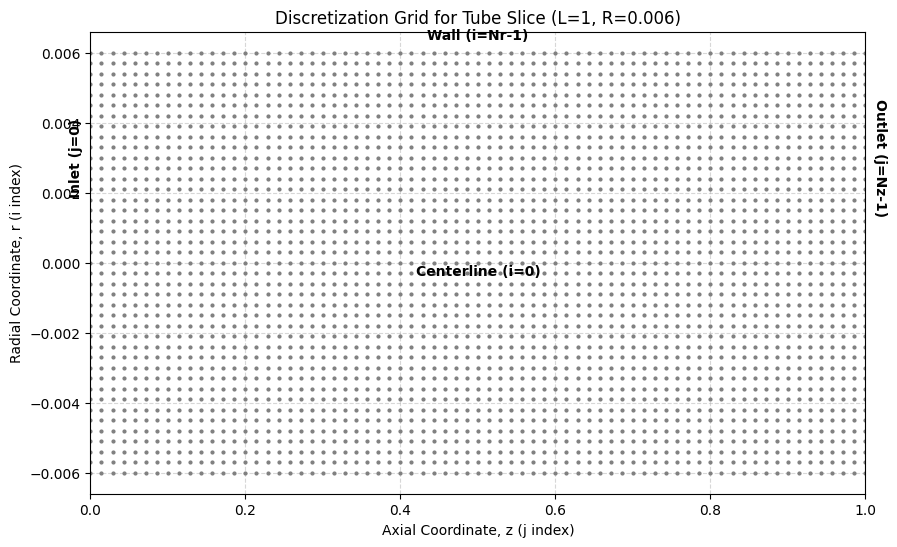

In [ ]:
# creación de grilla espejo para visualizar todo el tubo (2R)
r_grilla_mirrored = -r_grilla[::-1][:-1]
r_grilla_full = np.hstack((r_grilla_mirrored, r_grilla))


plt.figure(figsize=(10, 6))
ax = plt.gca()

for i in range(Nr):
    r_val = r_grilla[i]
    for j in range(Nz):
        z_val = z_grilla[j]

        ax.plot(z_val, r_val, 'o', color='gray', markersize=2)
        if r_val > 0:
            ax.plot(z_val, -r_val, 'o', color='gray', markersize=2)

r_min = -R * 1.10
r_max = R * 1.10

ax.set_ylim(r_min, r_max)
ax.set_xlim(0.0, L)

ax.set_xlabel('Axial Coordinate, z (j index)')
ax.set_ylabel('Radial Coordinate, r (i index)')
ax.set_title(f'Discretization Grid for Tube Slice (L={L}, R={R})')

ax.text(-0.01 * L, R/2, 'Inlet (j=0)', rotation=90, ha='right', va='center', fontweight='bold')
ax.text(L * 1.01, R/2, 'Outlet (j=Nz-1)', rotation=-90, ha='left', va='center', fontweight='bold')
ax.text(L/2, -0.01 * R, 'Centerline (i=0)', ha='center', va='top', fontweight='bold')
ax.text(L/2, R * 1.05, 'Wall (i=Nr-1)', ha='center', va='bottom', fontweight='bold')

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

### 2.3 Coeficientes SOR

In [ ]:
#Coeficientes horizontales
a = rho*c_p*Phi/(2*dz)*((i*dr)**2 - R**2) - k/(dz**2) #adelante
b = -(rho*c_p*Phi/(2*dz)*((i*dr)**2 - R**2) + k/(dz**2)) #atras

#Coeficientes radiales
c = -k/(dr**2)*(1+1/(2*i)) #hacia afuera
d = -k/(dr**2)*(1-1/(2*i)) #hacia adentro

#Coeficiente central
e = (2*k/(dz**2)+2*k/(dr**2))

#Coeficiente constante
f = 0

In [ ]:
#Parametros SOR
w = 1.6 #sobre-relajación
tol = 1e-4 #tolerancia

### 2.4 Iteración

In [ ]:
max_iter = 25000
#inicializar la matriz de soluciones
T = np.ones((Nr,Nz))*T_0

# Aplicamos las condiciones de borde
# Temperatura de entrada (para todo i)
T[:,0] = T_0

# Iniciamos el residuo total al comienzo de iteración con un valor arbitrario
residuo_total = 1

# Iniciamos contador para numero de iteraciones
cnt_it = 0

while residuo_total > tol:
    T_old = T.copy()  # Almacenar la solución anterior
    max_change = 0.0  # Usaremos el máximo cambio para la convergencia


    for pass_cb in range(2):
        current_parity = pass_cb


        #loop axial
        for j in range(1, Nz):

            #loop radio
            for i in range(Nr):

                if ((i + j) % 2) == current_parity:

                    T_current_val = T[i, j]

                    if i == 0 and j < Nz - 1:
                        T_GS = (4 * T[1, j] - T[2, j]) / 3.0
                        T_new = T_current_val + w * (T_GS - T_current_val)


                    elif j == 1 and i > 0 and i < Nr - 1:
                    #BC: T[i,1] = (3*T_0 + T[i,2])/4
                        T_new = (3 * T_0 + T[i, 2]) / 4.0

                    #BC
                    elif i == Nr - 1 and j > 0 and j < Nz:
                        flux_term = qrad * dr / k
                        T_new = T[i - 1, j] + flux_term


                    #nodos interiores
                    elif i > 0 and i < Nr - 1 and j > 1 and j < Nz - 1:



                        RHS = f - a*T[i+1,j] - b*T[i-1,j] - c*T[i,j+1] - d*T[i,j-1]
                        T_GS = RHS / e
                        T_new = T_current_val + w * (T_GS - T_current_val)


                    elif j == Nz - 1 and i >= 0:
                        T_new = T[i, j - 1]

                    else:
                        if j == Nz - 1:
                            T_new = T[i, j - 1]
                        else:
                            continue

                    # actualización
                    change = abs(T_new - T_current_val)
                    max_change = max(max_change, change)
                    T[i, j] = T_new

    #convergencia

    residuo_total = max_change

    # imprimir residuo cada 100 iteraciones
    if cnt_it % 100 == 0:
        print("Iteracion %d, Max Change: %.3e" % (cnt_it, residuo_total))

    # actualizar contador de iteraciones
    cnt_it += 1

    # agregar condición de salida de emergencia si no converge
    if cnt_it > max_iter:
        print("Advertencia: Se alcanzó el límite de iteraciones.")
        break

### 2.5 Visualización del perfil

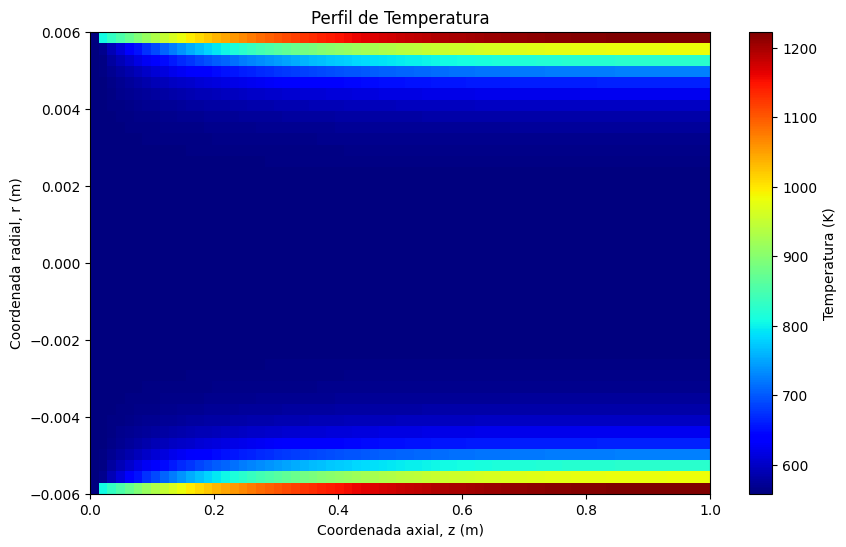

In [ ]:
T_solution = T
T_reflected = T_solution[1:][::-1, :]
T_full = np.vstack((T_reflected, T_solution))

#ploteo
T_plot_full = T_full
plt.figure(figsize=(10, 6))
full_extent = [0, L, -R, R]

im = plt.imshow(
    T_plot_full,
    aspect='auto',
    cmap='jet',
    origin='lower',
    extent=full_extent
)

#barra lateral leyenda
plt.colorbar(im, label='Temperatura (K)')


#coordenadas gráfico
plt.xlabel('Coordenada axial, z (m)')
plt.ylabel('Coordenada radial, r (m)')
plt.title('Perfil de Temperatura')

plt.show()